In [1]:
%cd /home/q123/Desktop/explo

import torch 
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.gibo.optim import GIBOptimizer
from src.optim import BOptimizer
from src.config import get_configs

logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

/home/q123/Desktop/explo


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.tester import Tester 

env_name = "Swimmer-v2"
kernel_name = "state"
kernel_name2 = "rbf"
delta = 2e-1
n_train = 100
n_test = 100
n_episodes = 5

In [5]:
env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 local_opt ="/home/q123/Desktop/explo/local_optima/"+env_name,
                 use_opt_states = True,
                 delta =delta,
                 n_train=n_train,n_test=n_test,n_episodes=n_episodes)

#### generate data for all experiments
train_data,test_data,opt_states = tester.generate_data()

MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]
set_train_datating trainig data of StateKernel
local_y 1.0361478328704834 local_opt tensor([ 0.2683, -0.0379, -0.3616,  0.0220,  0.5068,  0.2522,  0.4989, -0.1447,
        -0.4198,  0.4915])
 intial local opt reward : 1.031738555431366
Generating data
Done generating data


set_train_datating trainig data of StateKernel
##############################
covar_lengthscale max 0.5 / min 0.5                  covar_outputscale 1.9999998807907104                 noise 0.014999999664723873
##############################
##############################
covar_lengthscale max 0.33336445689201355 / min 0.33336445689201355                  covar_outputscale 0.009999999776482582                 noise 0.010000023059546947
##############################


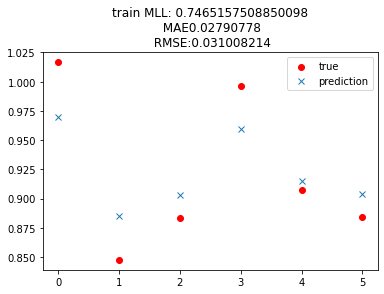

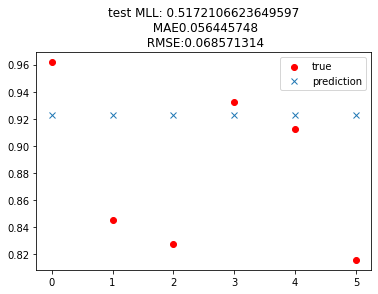

In [6]:
train_data,train_pred,test_data,test_pred,opt_data = tester.run(train_data,test_data,opt_states)

MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]


/home/q123/miniconda3/envs/explo/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Swimmer-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Swimmer-v3`.
  logger.warn(


local_y 1.0361478328704834 local_opt tensor([ 0.2683, -0.0379, -0.3616,  0.0220,  0.5068,  0.2522,  0.4989, -0.1447,
        -0.4198,  0.4915])
 intial local opt reward : 1.0312538504600526
##############################
covar_lengthscale max 0.5 / min 0.5                  covar_outputscale 1.9999998807907104                 noise 0.014999999664723873
##############################
##############################
covar_lengthscale max 0.33890339732170105 / min 0.33890339732170105                  covar_outputscale 0.009999999776482582                 noise 0.010000030510127544
##############################


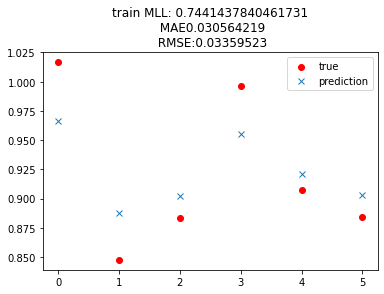

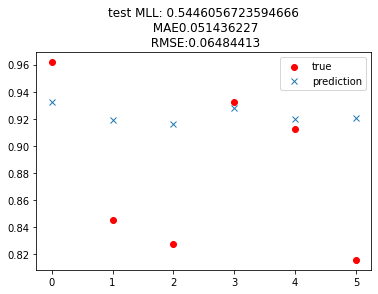

In [7]:
env_config,likelihood_config,kernel_config,_,_ = get_configs(env_name,kernel_name2)
model,objective_env = setup_experiment(env_config,kernel_config,likelihood_config)
tester = Tester(model,objective_env,
                 local_opt ="/home/q123/Desktop/explo/local_optima/"+env_name,
                 use_opt_states = True,
                 delta =delta,
                 n_train=n_train,n_test=n_test,n_episodes=n_episodes)

train_data,train_pred,test_data,test_pred,opt_data = tester.run(train_data,test_data,opt_states)

In [8]:
from sklearn.linear_model import ARDRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

train_x,train_y,train_s = train_data
test_x,test_y,test_s = test_data
local_opt,opt_states = opt_data

Phi_train = tester.model.mlp(train_x,opt_states).flatten(start_dim=1)
Phi_test = tester.model.mlp(test_x,opt_states).flatten(start_dim=1)
Y_train,Y_test = train_y,test_y

ard = ARDRegression(compute_score=True, n_iter=100).fit(Phi_train, Y_train)
Y_train_pred = ard.predict(Phi_train)
Y_test_pred = ard.predict(Phi_test)

def plot(x,best_x,y,y_hat):
    
    print(x.shape,best_x.shape)
    dist = torch.linalg.norm(x-best_x,dim=1)
    idx = torch.argsort(dist)
    y = y[idx]
    y_hat = y_hat[idx]
    x_plot = range(len(y))
    plt.scatter(x_plot,y,label="true",color="red")
    plt.errorbar(x_plot,y_hat,label="prediction",fmt="x")
    plt.title("MAE:"+str(mae(y,y_hat)) +"/ RMSE :"+str(mse(y,y_hat,squared=False)))


torch.Size([6, 18]) torch.Size([18])


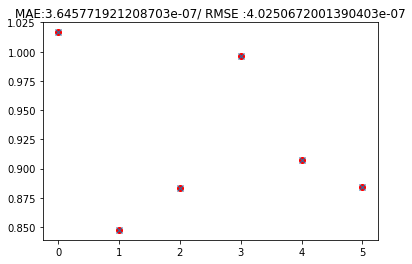

In [9]:
plot(train_x,local_opt.squeeze(),Y_train,Y_train_pred)

torch.Size([6, 18]) torch.Size([18])


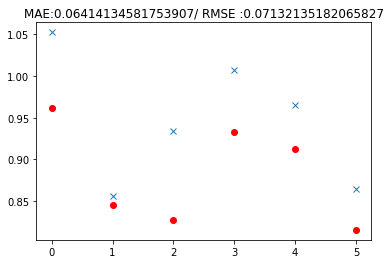

In [10]:
plot(test_x,local_opt.squeeze(),Y_test,Y_test_pred)

In [51]:

import gpytorch
import torch

covar_module = gpytorch.kernels.LinearKernel()
x1 = torch.randn(50, 3)
t1 = covar_module(x1).evaluate() # Returns a RootLazyTensor
x2 = torch.randn(51, 3)
t2 = covar_module(x2)

In [54]:
class LinerStateKernel(gpytorch.kernels.Kernel):
    
    def __init__(self,ard_num_dims,use_ard):
        
        super(LinerStateKernel,self).__init__()
        self.base_kernel = gpytorch.kernels.LinearKernel(ard_num_dims)
        self.base_kernel.lengthscales = torch.diag(torch.nn.Parameter(torch.randn(ard_num_dims)))
        
    
    def forward(self,x1,x2,**params):
        
        root = self.base_kernel.lengthscales
        rslt = self.base_kernel.forward(x1@root, x2@root)
        
        return rslt
        
                  